This jupyter notebook contains all the code for the flatiron, data science, module 3 (V2) project. In this notebook, a number of questions are posed and answered using hypothesis testing and statistical analysis using a modified Northwind database. The Northwind database contains operational data for a fictional, specialty grocery supplier.

## Import all libraries and the database using SQLite3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()
import scipy.stats as stats
from scipy.stats import kurtosis, skew
import requests
import sqlite3
import json
import numpy as np


conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

## Create functions to test the central limit theorem:
### get_sample(): randomly generates a sample (with n values) from the distribution
### get_sample_mean(): calculate the mean of the sample generated
### create_sample_distribution(): repeat these steps (dist_size number of times), and record the samples means into a new distribution, sample_dist

In [2]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    return sample

def get_sample_mean(sample):
    return sum(sample)/len(sample)

def create_sample_distribution(data, dist_size = 100, n = 30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

## Create functions to complete a welch's t-test for two distributions:
### welch_t(): calculates the t-statistic
### welch_df(): calculates the degrees of freedom
### p_value(): calculates the p-value using both the t-statistic and the degrees of freedom

In [3]:
def welch_t(a,b):
    numerator = a.mean() - b.mean()
    denominator = np.sqrt(a.var(ddof = 1)/a.size + b.var(ddof = 1)/b.size)
    return np.abs(numerator/denominator)

def welch_df(a,b):
    s1 = a.var(ddof = 1)
    s2 = b.var(ddof = 1)
    n1 = a.size
    n2 = b.size
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    return numerator/denominator

def p_value(a, b, two_sided = False):
    t = welch_t(a,b)
    print("Welch's T Statistic for Two Samples: ", t)
    df = welch_df(a,b)
    print("Effective Degrees of Freedom for Two Samples: ", df)
    p = 1-stats.t.cdf(np.abs(t),df)
    if two_sided:
        print("P-Value for Two-Sided Test: ", 2*p)
    else:
        print("P-Value for One-Sided Test: ", p)
    if (p < 0.05):
        print("The null hypothesis can be rejected")
    else:
        print ("The null hypothesis is accepted")

## Create a function, cohens_d, that calculates a standardized effect size for the two distributions:

In [4]:
def cohens_d(a,b):
    diff = a.mean() - b.mean()
    n1, n2 = len(a), len(b)
    var1 = a.var()
    print("Sample 1 Variance: ", var1)
    var2 = b.var()
    print("Sample 2 Variance: ", var2)
    pooled_var = (n1*var1 + n2*var2)/(n1 + n2)
    print("Pooled Variance: ", pooled_var)
    d = diff/(np.sqrt(pooled_var))
    print("Cohen's d: ", d)
    print("\nReference on Cohen's d:\nSmall effect = 0.2\nMedium Effect = 0.5\nLarge Effect = 0.8\n")

# 1. null hypothesis: 
### There is not a significant increase in quantities sold when items are discounted.
# 1. alternative hypothesis:
### There is a significant increase in quantities sold when items are discounted.

In [5]:
# query quantities sold for items with no discount

cur.execute("SELECT * FROM OrderDetail WHERE Discount = 0.00;")
da = pd.DataFrame(cur.fetchall())
da.columns = [x[0] for x in cur.description]
db = da['Quantity']

In [6]:
# check all discount percentages
# query quantities sold for items with any discount

cur.execute("SELECT * FROM OrderDetail WHERE Discount != 0.00;")
dd = pd.DataFrame(cur.fetchall())
dd.columns = [x[0] for x in cur.description]
print(dd['Discount'].unique())
de = dd['Quantity']

[0.15 0.05 0.2  0.25 0.1  0.02 0.03 0.04 0.06 0.01]


Welch's T Statistic for Two Samples:  6.239069142123973
Effective Degrees of Freedom for Two Samples:  1561.7678231942148
P-Value for One-Sided Test:  2.8282065578366655e-10
The null hypothesis can be rejected

Sample 1: Quanities Sold with any Discount
Sample 2: Quanities Sold with no Discoun

Sample 1 Variance:  430.93782787748984
Sample 2 Variance:  306.2795924332757
Pooled Variance:  354.7545814366406
Cohen's d:  0.28641058366376676

Reference on Cohen's d:
Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8



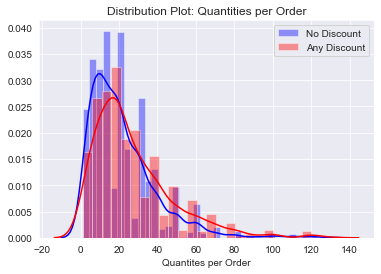

In [7]:
# is there a statistical increase in sales quantity when items are discounted versus not
# one-tailed t-test

no_discount = np.array(db)
any_discount = np.array(de)

sns.distplot(no_discount, label = "No Discount", color = 'blue')
sns.distplot(any_discount, label = "Any Discount", color = 'red')
plt.legend()
plt.title('Distribution Plot: Quantities per Order')
plt.xlabel('Quantites per Order')
plt.show

p_value(any_discount, no_discount, False)
print('\nSample 1: Quanities Sold with any Discount\nSample 2: Quanities Sold with no Discoun\n')
cohens_d(any_discount, no_discount)

In [8]:
# are the distributions normal?
# if p value > 0.05, the distibution is normal 

print(stats.normaltest(any_discount))
print(stats.normaltest(no_discount))

NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)
NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)


NormaltestResult(statistic=4.065440293123988, pvalue=0.13097875473062792)


<function matplotlib.pyplot.show(*args, **kw)>

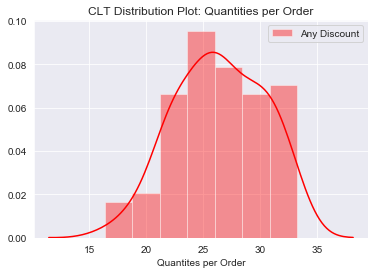

In [9]:
# do the discounted samples adhere to the central limit theorem normality distribution

any_discount_CLT = create_sample_distribution(any_discount)
sns.distplot(any_discount_CLT, color = 'red', label = "Any Discount")
print(stats.normaltest(any_discount_CLT))
plt.legend()
plt.title('CLT Distribution Plot: Quantities per Order')
plt.xlabel('Quantites per Order')
plt.show

NormaltestResult(statistic=1.6856266733535905, pvalue=0.4304976832436017)


<function matplotlib.pyplot.show(*args, **kw)>

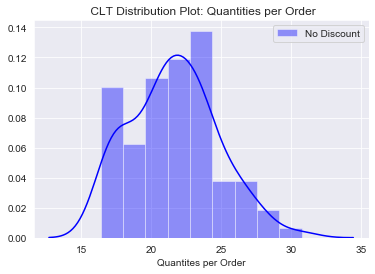

In [10]:
# do the non discounted samples adhere to the central limit theorem normality distribution

no_discount_CLT = create_sample_distribution(no_discount)
sns.distplot(no_discount_CLT, color = 'blue', label = 'No Discount')
print(stats.normaltest(no_discount_CLT))
plt.legend()
plt.title(' CLT Distribution Plot: Quantities per Order')
plt.xlabel('Quantites per Order')
plt.show


Are quantities sold with a 0.15% discount significantly different than with no discount?

Welch's T Statistic for Two Samples:  3.8356620426605934
Effective Degrees of Freedom for Two Samples:  182.9770822584441
P-Value for One-Sided Test:  8.610364721817199e-05
The null hypothesis can be rejected

Sample 1: Quanities Sold with Discount
Sample 2: Quanities Sold with no Discoun

Sample 1 Variance:  434.9877074120654
Sample 2 Variance:  306.2795924332757
Pooled Variance:  319.9886657383435
Cohen's d:  0.37269784425960373

Reference on Cohen's d:
Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8


Are quantities sold with a 0.05% discount significantly different than with no discount?

Welch's T Statistic for Two Samples:  3.700844260760871
Effective Degrees of Freedom for Two Samples:  217.36031100748286
P-Value for One-Sided Test:  0.0001361674721642725
The null hypothesis can be rejected

Sample 1: Quanities Sold with Discount
Sample 2: Quanities Sold with no Discoun

Sample 1

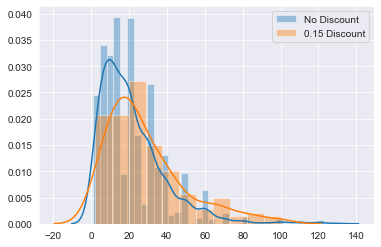

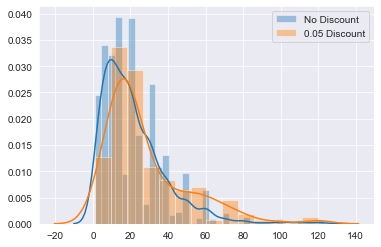

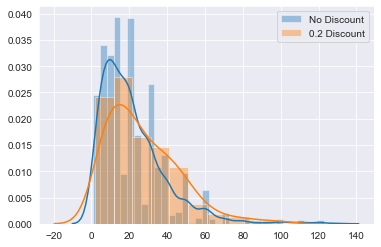

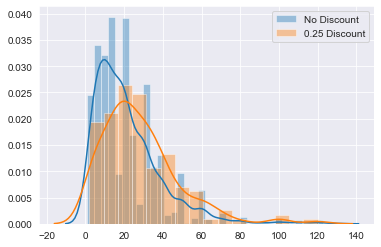

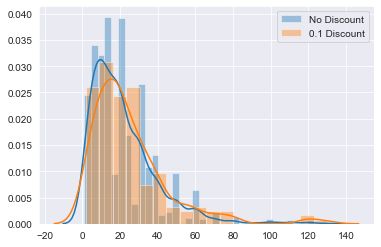

In [11]:
# Which discounts is there a significant difference for quantity versus no discount?
# discounts '.02,.03, .04, .06, .01' each had less than 5 orders, so they were dropped from the simulation
# one-tailed t-tests

discounts = [0.15, 0.05, 0.2 , 0.25, 0.1]

for discount in discounts:
    cur.execute(f'SELECT Quantity FROM OrderDetail WHERE Discount = {discount};')
    dc = pd.DataFrame(cur.fetchall())
    dc.columns = [x[0] for x in cur.description]
    particular_discount = np.array(dc)
    plt.figure()
    sns.distplot(no_discount, label = "No Discount")
    sns.distplot(particular_discount, label = f"{discount} Discount")
    plt.legend()
    plt.show
    print('\nAre quantities sold with a',f"{discount}% discount significantly different than with no discount?\n")
    p_value(particular_discount, no_discount, False)
    print('\nSample 1: Quanities Sold with Discount\nSample 2: Quanities Sold with no Discoun\n')
    cohens_d(particular_discount, no_discount)

# 2. null hypothesis: 
### There is not a significant difference in sales revenue per item when discounted.
# 2. alternative hypothesis:
### There is a significant difference in sales revenue per item when discounted. 

In [12]:
# find the highest quantity selling item to investigate

cur.execute(""" SELECT p.ProductName, od.ProductId, SUM(od.Quantity)
                FROM 'OrderDetail' od
                JOIN 'Product' p
                ON od.ProductId = p.Id
                GROUP BY ProductId
                ORDER BY SUM(od.Quantity) DESC
                LIMIT 1;""")
dk = pd.DataFrame(cur.fetchall())
dk.columns = [x[0] for x in cur.description]
dk

,ProductName,ProductId,SUM(od.Quantity)
0,Camembert Pierrot,60,1577


In [13]:
# find the total cost of orders for productId 60 when not on sale

cur.execute(""" SELECT *
                FROM 'OrderDetail'
                WHERE (ProductId = 60) AND (Discount == 0.00);""")
dl = pd.DataFrame(cur.fetchall())
dl.columns = [x[0] for x in cur.description]
dl['TotalCost'] = (dl['UnitPrice'] * dl['Quantity'])
dl = dl.drop(['UnitPrice', 'Quantity', 'Discount', 'OrderId'], axis = 1)

In [14]:
# find the total cost of orders for productid 60 when on sale

cur.execute(""" SELECT *
                FROM 'OrderDetail'
                WHERE (ProductId = 60) AND (Discount != 0.00);""")
dm = pd.DataFrame(cur.fetchall())
dm.columns = [x[0] for x in cur.description]
dm['TotalCost'] = (dm['UnitPrice'] * dm['Quantity']*(1-dm['Discount']))
dm = dm.drop(['UnitPrice', 'Quantity', 'Discount', 'OrderId'], axis = 1)

Welch's T Statistic for Two Samples:  0.3436622881250188
Effective Degrees of Freedom for Two Samples:  46.413692355315206
P-Value for Two-Sided Test:  0.7326522594480509
The null hypothesis is accepted

Sample 1: Discounted Item Order Revenue 
Sample 2: Full Price Item Order Revenue

Sample 1 Variance:  490407.1947584121
Sample 2 Variance:  460763.43428571423
Pooled Variance:  474132.1890086956
Cohen's d:  0.09901264431065293

Reference on Cohen's d:
Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8



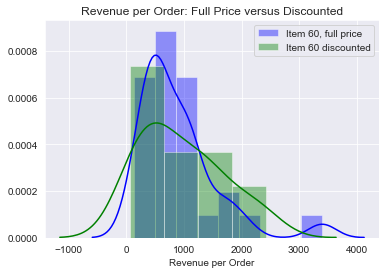

In [15]:
# is a statistical difference of sales revenue between a product that is discounted verus not.
# two tailed t-test

ID60_no_sale = np.array(dl['TotalCost'])
ID60_discounted = np.array(dm['TotalCost'])

sns.distplot(ID60_no_sale, label = "Item 60, full price", color = 'blue')
sns.distplot(ID60_discounted, label = "Item 60 discounted", color = 'green')
plt.legend()
plt.title('Revenue per Order: Full Price versus Discounted')
plt.xlabel('Revenue per Order')
plt.show

p_value(ID60_discounted, ID60_no_sale, True)
print('\nSample 1: Discounted Item Order Revenue \nSample 2: Full Price Item Order Revenue\n')
cohens_d(ID60_discounted, ID60_no_sale)


# 3. null hypothesis: 
### The region of the customer has no significant effect on quantities per order.
# 3. alternative hypothesis:
### The region of the customer has a significant effect on quantities per order.

Welch's T Statistic for Two Samples:  1.094264026925421
Effective Degrees of Freedom for Two Samples:  1630.743564691244
P-Value for Two-Sided Test:  0.2740007982631001
The null hypothesis is accepted

Sample 1: European Customer Order Quantity 
Sample 2: Americas Customer Order Quantity

Sample 1 Variance:  360.6402342589309
Sample 2 Variance:  375.8248499504691
Pooled Variance:  366.38378956862726
Cohen's d:  0.04977592446123652

Reference on Cohen's d:
Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8



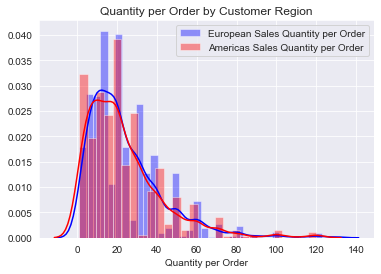

In [16]:
# is there a statistical difference in quantites sold from customers in europe versus the americas
# two tailed t-test

cur.execute(""" SELECT c.Region, od.Quantity
                FROM 'Customer' c
                JOIN 'Order' o
                ON c.Id = o.CustomerId
                JOIN 'OrderDetail' od
                ON o.Id = od.OrderId;""")
dk = pd.DataFrame(cur.fetchall())
dk.columns = [x[0] for x in cur.description].copy()
euro_region = dk.loc[dk['Region'].isin(['Western Europe', 'British Isles','Northern Europe', 'Southern Europe', 'Scandinavia', 'Eastern Europe'])].copy()
americas_region = dk.loc[dk['Region'].isin(['Central America','North America','South America'])].copy()

euro_sales = np.array(euro_region['Quantity'])
americas_sales = np.array(americas_region['Quantity'])

sns.distplot(euro_sales, label = "European Sales Quantity per Order", color = 'blue')
sns.distplot(americas_sales, label = "Americas Sales Quantity per Order", color = 'red')
plt.legend()
plt.title('Quantity per Order by Customer Region')
plt.xlabel('Quantity per Order')
plt.show

p_value(euro_sales, americas_sales, True)
print('\nSample 1: European Customer Order Quantity \nSample 2: Americas Customer Order Quantity\n')
cohens_d(euro_sales, americas_sales)

# 4. null hypothesis: 
### The region of the sales representative has no significant effect on quantities per order.
# 4. alternative hypothesis:
### The region of the sales representative has a significant effect on quantities per order.

Welch's T Statistic for Two Samples:  0.580087077931603
Effective Degrees of Freedom for Two Samples:  829.4982182597644
P-Value for Two-Sided Test:  0.562013429582247
The null hypothesis is accepted

Sample 1: British Isles Sales Reps Order Quantity 
Sample 2: North American Sales Reps Order Quantity

Sample 1 Variance:  359.67490818629216
Sample 2 Variance:  349.12550152790067
Pooled Variance:  352.2210008141301
Cohen's d:  0.03272641935965369

Reference on Cohen's d:
Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8



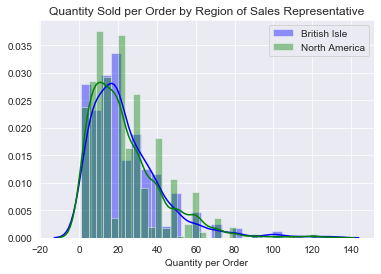

In [17]:
# is a statistical difference between quantities sold by british isles versus north american sales reps
# two tailed t test

cur.execute(""" SELECT e.Region, od.OrderId, od.Quantity
                FROM Employee e
                JOIN 'Order' o 
                ON e.Id = o.EmployeeId
                Join 'OrderDetail' od
                ON o.Id = od.OrderID
                WHERE Title = 'Sales Representative';""")
dj = pd.DataFrame(cur.fetchall())
dj.columns = [x[0] for x in cur.description]
dj = dj.drop(['OrderId'], axis = 1)

BritishIsles_sales = dj.loc[(dj['Region'] == 'British Isles')]
NorthAmerica_sales = dj.loc[(dj['Region'] == 'North America')]

BritishIsles_sales = BritishIsles_sales.drop(['Region'], axis = 1)
NorthAmerica_sales = NorthAmerica_sales.drop(['Region'], axis = 1)

BI_sales = np.array(BritishIsles_sales['Quantity'])
NA_sales = np.array(NorthAmerica_sales['Quantity'])

sns.distplot(BritishIsles_sales, label = "British Isle", color = 'blue')
sns.distplot(NorthAmerica_sales, label = "North America", color = 'green')
plt.legend()
plt.title('Quantity Sold per Order by Region of Sales Representative')
plt.xlabel('Quantity per Order')
plt.show

p_value(BI_sales, NA_sales, True)
print('\nSample 1: British Isles Sales Reps Order Quantity \nSample 2: North American Sales Reps Order Quantity\n')
cohens_d(BI_sales, NA_sales)

In [18]:
# # do customers from different regions generate different sales quantity per order?
# # did not produce normal distributions, using quantity of orders instead

# cur.execute(""" SELECT c.Region, od.UnitPrice, od.Quantity, od.Discount
#                 FROM 'Customer' c
#                 JOIN 'Order' o
#                 ON c.Id = o.CustomerId
#                 JOIN 'OrderDetail' od
#                 ON o.Id = od.OrderId;""")
# dk = pd.DataFrame(cur.fetchall())
# dk.columns = [x[0] for x in cur.description].copy()
# euro_region = dk.loc[dk['Region'].isin(['Western Europe', 'British Isles','Northern Europe', 'Southern Europe', 'Scandinavia', 'Eastern Europe'])].copy()
# euro_region['TotalCost'] = (euro_region['UnitPrice'] * euro_region['Quantity'] * (1-euro_region['Discount'])).copy()
# euro_region = euro_region.drop(['UnitPrice', 'Quantity', 'Discount'], axis = 1).copy()


# americas_region = dk.loc[dk['Region'].isin(['Central America','North America','South America'])].copy()
# americas_region['TotalCost'] = (americas_region['UnitPrice'] * americas_region['Quantity']*(1-americas_region['Discount'])).copy()
# americas_region = americas_region.drop(['UnitPrice', 'Quantity', 'Discount'], axis = 1).copy()


# euro_sales = np.array(euro_region['TotalCost'])
# americas_sales = np.array(americas_region['TotalCost'])

# sns.distplot(euro_sales, label = "European Sales Revenue per Order", color = 'blue')
# sns.distplot(americas_sales, label = "Americas Sales Revenue per Order", color = 'red')
# plt.legend()
# plt.title('Revenue per Order by Customer Region')
# plt.xlabel('Revenue per Order')
# plt.show

# p_value(euro_sales, americas_sales, True)
# print('\nSample 1: European Customer Order Revenue \nSample 2: Americas Customer Order Revenue\n')
# skewness_kurtosis(euro_sales, americas_sales)
# cohens_d(euro_sales, americas_sales)

In [19]:
# # is a statistical difference between british isles and north american sales reps sale revenue per order
# # these samples did not result in normal distributions, using quantity per order instead

# cur.execute(""" SELECT e.Region, od.OrderId, od.UnitPrice, od.Quantity, od.Discount
#                 FROM Employee e
#                 JOIN 'Order' o 
#                 ON e.Id = o.EmployeeId
#                 Join 'OrderDetail' od
#                 ON o.Id = od.OrderID
#                 WHERE Title = 'Sales Representative';""")
# dj = pd.DataFrame(cur.fetchall())
# dj.columns = [x[0] for x in cur.description]
# dj['TotalCost'] = (dj['UnitPrice'] * dj['Quantity']*(1-dj['Discount']))
# dj = dj.drop(['UnitPrice', 'Quantity', 'Discount', 'OrderId'], axis = 1)

# BritishIsles_sales = dj.loc[(dj['Region'] == 'British Isles')]
# NorthAmerica_sales = dj.loc[(dj['Region'] == 'North America')]

# BritishIsles_sales = BritishIsles_sales.drop(['Region'], axis = 1)
# NorthAmerica_sales = NorthAmerica_sales.drop(['Region'], axis = 1)

# BI_sales = np.array(BritishIsles_sales['TotalCost'])
# NA_sales = np.array(NorthAmerica_sales['TotalCost'])

# sns.distplot(BritishIsles_sales, label = "British Isle", color = 'blue')
# sns.distplot(NorthAmerica_sales, label = "North America", color = 'green')
# plt.legend()
# plt.title('Revenue per Order by Region of Sales Representative')
# plt.xlabel('Revenue per Order')
# plt.show

# p_value(BI_sales, NA_sales, True)
# print('\nSample 1: British Isles Sales Reps Order Revenue \nSample 2: North American Sales Reps Order Revenue\n')
# skewness_kurtosis(BI_sales, NA_sales)
# cohens_d(BI_sales, NA_sales)

In [20]:
# # Employee IDs for female sales reps

# cur.execute("""SELECT e.Id AS Female_Sales_Rep_IDs
#                 FROM Employee e
#                 JOIN 'Order' o
#                 ON e.Id = o.EmployeeId
#                 WHERE (e.Title = 'Sales Representative') AND (e.TitleOfCourtesy != 'Mr.')
#                 GROUP BY e.Id;""")
# dg = pd.DataFrame(cur.fetchall())
# dg.columns = [x[0] for x in cur.description]
# dg

In [21]:
# # Employee IDs for male sales reps


# cur.execute("""SELECT e.Id AS Male_Sales_Rep_IDs
#                 FROM Employee e
#                 JOIN 'Order' o
#                 ON e.Id = o.EmployeeId
#                 WHERE (e.Title = 'Sales Representative') AND (e.TitleOfCourtesy = 'Mr.')
#                 GROUP BY e.Id;""")
# dh = pd.DataFrame(cur.fetchall())
# dh.columns = [x[0] for x in cur.description]
# dh

In [22]:
# # is a statistical difference between revenue per order of female versus male sales reps
# # two tailed t-test

# cur.execute("""SELECT od.OrderId,  o.EmployeeId, od.UnitPrice, od.Quantity, od.Discount
#                 FROM 'OrderDetail' od
#                 JOIN 'Order' o
#                 on od.OrderId = o.Id""")
# di = pd.DataFrame(cur.fetchall())
# di.columns = [x[0] for x in cur.description]
# di['TotalCost'] = (di['UnitPrice'] * di['Quantity']*(1-di['Discount']))
# di = di.drop(['UnitPrice', 'Quantity', 'Discount'], axis = 1)
# di = di.groupby(['OrderId', 'EmployeeId']).sum()
# di = di.reset_index()
# female_sales = di.loc[di['EmployeeId'].isin([1,3,4,9])]
# male_sales = di.loc[di['EmployeeId'].isin([6,7])]
# female_sales = female_sales.drop(['EmployeeId', 'OrderId'], axis = 1)
# male_sales = male_sales.drop(['EmployeeId', 'OrderId'], axis = 1)

# f_sales = np.array(female_sales['TotalCost'])
# m_sales = np.array(male_sales['TotalCost'])

# sns.distplot(f_sales, label = "Female", color = 'red')
# sns.distplot(m_sales, label = "Male", color = 'blue')
# plt.legend()
# plt.title('Revenue per Order by Gender of Sales Representative')
# plt.xlabel('Revenue per Order')
# plt.show

# p_value(f_sales, m_sales, True)
# print('\nSample 1: Female Sales Reps Order Revenue\nSample 2: Male Sales Reps Order Revenue\n')
# skewness_kurtosis(f_sales, m_sales)
# cohens_d(f_sales, m_sales)